In [351]:
import numpy as np
import time
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.ensemble import AdaBoostClassifier as AdaBoost
from sklearn.model_selection import train_test_split
import sklearn.preprocessing as preprocessing
import sklearn.metrics as metrics

In [352]:
data = pd.read_csv('diabetes_012_health_indicators_BRFSS2015.csv', dtype='int') # load a dataframe with the siabetes health indicators dataset

In [353]:
data_x = data.iloc[:,1:].copy() # dataframe of all indicators
data_y = data.iloc[:,0].copy() # datafrma with label - had diametes or no diabetes

In [354]:
for col in data_x.columns:
    print(col, data_x[col].unique())

HighBP [1 0]
HighChol [1 0]
CholCheck [1 0]
BMI [40 25 28 27 24 30 34 26 33 21 23 22 38 32 37 31 29 20 35 45 39 19 47 18
 36 43 55 49 42 17 16 41 44 50 59 48 52 46 54 57 53 14 15 51 58 63 61 56
 74 62 64 66 73 85 60 67 65 70 82 79 92 68 72 88 96 13 81 71 75 12 77 69
 76 87 89 84 95 98 91 86 83 80 90 78]
Smoker [1 0]
Stroke [0 1]
HeartDiseaseorAttack [0 1]
PhysActivity [0 1]
Fruits [0 1]
Veggies [1 0]
HvyAlcoholConsump [0 1]
AnyHealthcare [1 0]
NoDocbcCost [0 1]
GenHlth [5 3 2 4 1]
MentHlth [18  0 30  3  5 15 10  6 20  2 25  1  4  7  8 21 14 26 29 16 28 11 12 24
 17 13 27 19 22  9 23]
PhysHlth [15  0 30  2 14 28  7 20  3 10  1  5 17  4 19  6 12 25 27 21 22  8 29 24
  9 16 18 23 13 26 11]
DiffWalk [1 0]
Sex [0 1]
Age [ 9  7 11 10  8 13  4  6  2 12  5  1  3]
Education [4 6 3 5 2 1]
Income [3 1 8 6 4 7 2 5]


### Data Pre-Processing

###### Since BMI ranges from 12 to 98, we can categorize it as 1 - underweight (<18), 2 - healthy (19-24), 3 - overweight (25-29), 4 - obese (30-39), 5 - extremely obese (>39)

In [355]:
data_x['BMI'] = data_x['BMI'].replace(np.arange(0,19),1).replace(np.arange(19,25),2).replace(np.arange(25, 30),3).replace(np.arange(30, 39), 4).replace(np.arange(39, 99),5)

##### One-hot encode dependent variable 
In some of the models we will build, we would use a one hot-encoded label vector 

In [245]:
enc = preprocessing.OneHotEncoder().fit(np.array(data_y).reshape([-1,1]))
data_y_ohe = enc.transform(np.array(data_y).reshape([-1,1])).toarray()

### Data Vizualization

#### Number of classes

Number of observations with no diabetes: 213703
Number of observations with pre-diabetes: 4631
Number of observations with diabetes: 35346


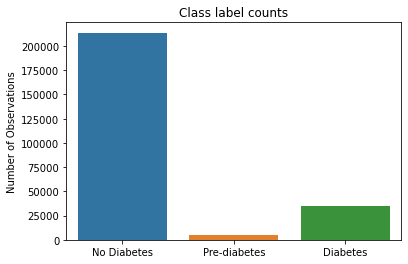

In [356]:
sns.countplot(x = data_y)
plt.xticks([0,1,2], ['No Diabetes', 'Pre-diabetes', 'Diabetes'])
plt.xlabel('')
plt.ylabel('Number of Observations')
plt.title('Class label counts')

print('Number of observations with no diabetes:', data_y[data_y==0].count())
print('Number of observations with pre-diabetes:', data_y[data_y==1].count())
print('Number of observations with diabetes:', data_y[data_y==2].count())

There is a class imbalance in the CDC diabetes dataset. The number of pre-diabetes and diabetes cases is relatively very small compared to the no diabetes cohort.

#### Train-Test Split, Use test dataset as hold-out set

In [375]:
train_x,test_x,train_y,test_y = train_test_split(data_x,data_y, test_size = 0.1, random_state = 32)

In [370]:
test_x.shape

(25368, 21)

In [379]:
x=preprocessing.StandardScaler()
x.fit(train_x)


StandardScaler()

In [381]:
x.transform(train_x)[0]

array([ 1.1540812 , -0.85815932,  0.19761654,  0.95940505,  1.12005916,
       -0.20546526, -0.32283242,  0.56691061,  0.75965648,  0.48128544,
       -0.24441288,  0.22672066, -0.30231452,  0.4577643 ,  0.10889262,
        1.23441234,  2.22530447, -0.88576509, -0.66549563, -0.05128467,
       -0.02575314])

#### Logistic Regression - multi-class

In [253]:
logistic_clf_model = LogisticRegression(multi_class = 'ovr', max_iter=10000)
logistic_clf_model.fit(train_x,train_y) # train logistic regression on training data using one vs rest
logistic_clf_predict = logistic_clf_model.predict(test_x)

#### Logistic Regression - model performance on test set

In [293]:
cm_logistic_clf = metrics.confusion_matrix(logistic_clf_predict, test_y, labels = [0,1,2])
cm_logistic_clf =  pd.DataFrame(cm_logistic_clf, columns= ['No Diabetes', 'Pre-diabetes', 'Diabetes'], index =  ['No Diabetes', 'Pre-diabetes', 'Diabetes'])
print('\t \033[1m  Confusion Matrix \n \n  \033[0m', '\t  \t Actual')
cm_logistic_clf

	   Confusion Matrix 
 
   	  	 Actual


,No Diabetes,Pre-diabetes,Diabetes
No Diabetes,20849,414,2834
Pre-diabetes,0,0,0
Diabetes,560,59,652


In [294]:
print('F1-score for logistic regression classifier for predicting 0, 1, 2 labels:', metrics.f1_score(logistic_clf_predict, test_y, labels = [0,1,2], average = None))

F1-score for logistic regression classifier for predicting 0, 1, 2 labels: [0.91631873 0.         0.27412235]


If we classify all the observations as no diabetes: 

                                           Actual
                                  No Diabetes	Pre-diabetes	Diabetes
    
                   No Diabetes    	21409	         420        	3539
                   
     Predicted     Pre-diabetes  	  0	              0	            0

                   Diabetes	          0 	          0	            0

In [256]:
print('F1-score when we classify all observations as no-diabetes:', metrics.f1_score(np.zeros(len(logistic_clf_predict)), test_y, labels = [0,1,2], average = None))

F1-score when we classify all observations as no-diabetes: [0.91536439 0.         0.        ]


In [348]:
test_y_ohe = enc.transform(np.array(test_y).reshape([-1,1])).toarray()
logistic_clf_predict_prob = logistic_clf_model.predict_proba(test_x)
print('ROC score:', metrics.roc_auc_score(test_y_ohe, logistic_clf_predict_prob))

ROC score: 0.7891539503036644


### K Nearest Neighbors

In [257]:
train_x_small, val_x, train_y_small, val_y = train_test_split(train_x, train_y, test_size = 0.1, random_state = 32)

In [259]:
KNN_model = KNN(n_neighbors = 5)
KNN_model.fit(train_x_small, train_y_small)

KNeighborsClassifier()

In [270]:
acc_val_knn = []
for k in np.arange(30,60, 5):
    KNN_model = KNN(n_neighbors = k)
    KNN_model.fit(train_x_small, train_y_small)
    acc_val_knn.append(KNN_model.score(val_x, val_y)) # compute accuracy of predictiosn on validation set

Text(0, 0.5, ' Validation Accuracy')

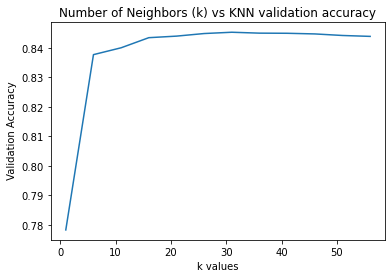

In [288]:
plt.plot(np.arange(1, 60, 5), acc_val_knn)
plt.title('Number of Neighbors (k) vs KNN validation accuracy')
plt.xlabel('k values')
plt.ylabel(' Validation Accuracy')

We can see that the optimal K value is somewhere between 1 and 12

In [279]:
acc_val_knn = []
for k in np.arange(1, 12, 2):
    KNN_model = KNN(n_neighbors = k)
    KNN_model.fit(train_x_small, train_y_small)
    acc_val_knn.append(KNN_model.score(val_x, val_y)) # compute accuracy of predictiosn on validation set

Text(0, 0.5, ' Validation Accuracy')

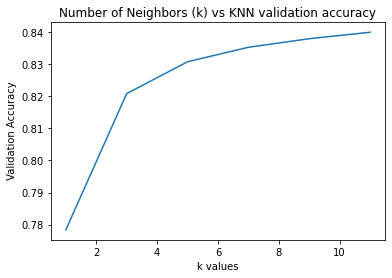

In [285]:
plt.plot(np.arange(1, 12, 2), acc_val_knn)
plt.title('Number of Neighbors (k) vs KNN validation accuracy')
plt.xlabel('k values')
plt.ylabel(' Validation Accuracy')

Hence optimal k value is 5

In [289]:
k = 5
KNN_model = KNN(n_neighbors = k)
KNN_model.fit(train_x, train_y)
KNN_predict = KNN_model.predict(test_x)

#### KNN Model Performance

In [291]:
cm_KNN = metrics.confusion_matrix(KNN_predict, test_y, labels = [0,1,2])
cm_KNN =  pd.DataFrame(cm_KNN, columns= ['No Diabetes', 'Pre-diabetes', 'Diabetes'], index =  ['No Diabetes', 'Pre-diabetes', 'Diabetes'])
print('\t \033[1m  Confusion Matrix \n \n  \033[0m', '\t  \t Actual')
cm_KNN

	   Confusion Matrix 
 
   	  	 Actual


,No Diabetes,Pre-diabetes,Diabetes
No Diabetes,20399,403,2814
Pre-diabetes,15,0,9
Diabetes,995,70,663


In [296]:
print('F1-score for KNN for predicting 0, 1, 2 labels:', metrics.f1_score(KNN_predict, test_y, labels = [0,1,2], average = None))

F1-score for KNN for predicting 0, 1, 2 labels: [0.90611882 0.         0.2543153 ]


In [350]:
KNN_predict_prob = KNN_model.predict_proba(test_x)
print('ROC score:', metrics.roc_auc_score(test_y_ohe, KNN_predict_prob))

ROC score: 0.6481962981437928


### Ada-Boost

In [371]:
test_x.shape

(25368, 21)